---
# [ EX03 ] 시계열 데이터 예측 : 삼성전자 주가
---
#### * 사용 모델 : ARIMA
#### * 데이터 : 과거 삼성전자 주가 일자별 시세
---

## Step 0. 환경설정

In [166]:
# 데이터 경로 준비
# mkdir -p ~/aiffel/stock_precition/ata
# ln -s ~/data/* ~/aiffel/stock_prediction/data

In [167]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import statsmodels
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Step 1. 데이터 불러오기
#### * 데이터 소스 : 005930.KS.csv(Yahoo Finance)
#### * 컬럼 종류 : Date(거래일자), Open(시가), High(고가), Low(저가), Adj Close(수정종가), Volume(거래량)
#### * 사용 컬럼 : Close(종가)

In [168]:
# 시계열 데이터 불러와서 기본 확인
# 클라우드서버 경로 지정해 주고, 파일 읽어들여 데이터프레임 ts에 저장
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
ts_original = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True)
print(type(ts_original))
ts_original.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [169]:
# 사용할 데이터는 high 이므로 추려서 새로운 데이터프레임음 만들고 시리즈로 변경함
ts = ts_original['Close']
print(type(ts))
print(ts)

<class 'pandas.core.series.Series'>
Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
               ...   
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, Length: 250, dtype: float64


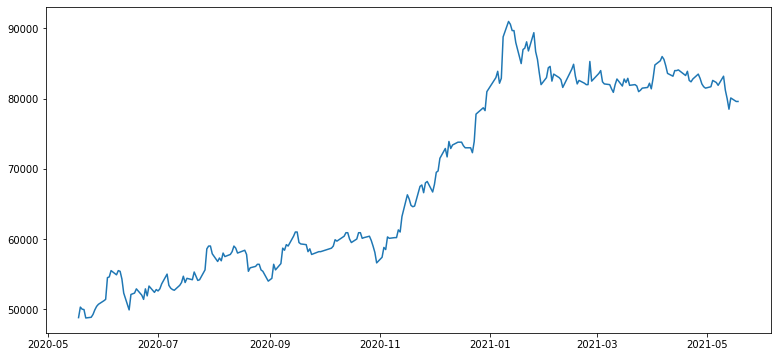

In [170]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  # 차트 기본 사이즈 설정

# 시계열 데이터를 차트로 그려봄
plt.plot(ts)

## Step 2. 전처리 수행
#### * 결측치 처리
#### * 로그 변환 

In [171]:
# 결측치 처리
ts_na=ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력 => 결측치 없음
#plt.plot(ts)
#plt.show()

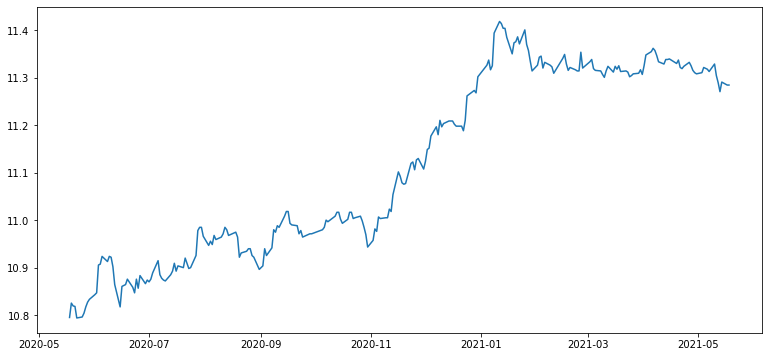

In [172]:
# 로그 변환 : 분석을 용이하게 하기 위해 큰 값은 크게, 작은 값은 작게 조정
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

## Step 3. 안정적 시계열로 가공
#### 방법 1. 직접 작업으로 로그함수 변환 -> Moving Average제거(추세trend 상쇄) -> 차분(계절성seasonality 상쇄)

#### 방법 2. 함수 이용 시계열 분해 : seasonal_decomose() 활용 => trend, seasonality 분리
##### ( 프로젝트에서는 방법2를 사용함)

### Step 3-1. 시계열 안정성 분석을 위한 함수 정의
#### * 정성적 그래프 분석 함수
#### * 정량적 분석 Augmented Dicky-Fully Test 함수
##### > p-value :  귀무가설이 참이라고 가정했을 때 표본 통계치 관측될 확률=>낮으면 귀무가설 기각, 대립가설 채택. 0에 가까우면 기각, 1에 가까우면 채택

In [173]:
# 정성적 그래프 분석  시계열 데이터의 이동평균, 이동표준편차를 확인하기 위한 함수를 정의
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
#정량적 Augmented Dicky-Fuller Test   
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### Step 3-2. 시계열 가공 방법1  => 본 프로젝트에서는 사용하지 않음
#### 3-2-1. 추세 상쇄 : moving average

In [174]:
## 추세(Trend) 상쇄하기 => Moving average 제거
#moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
#plt.plot(ts_log)
#plt.plot(moving_avg, color='red')

In [175]:
## ts_log 에서 빼줘서 변화량을 제거해 줌
#ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
#ts_log_moving_avg.head(15)

In [176]:
## window 사이즈로 인해 발생되는 결측치 제거
#ts_log_moving_avg.dropna(inplace=True)
#ts_log_moving_avg.head(15)

In [177]:
## 정성적 그래프 분석
#plot_rolling_statistics(ts_log, window=12)

##정량적 Augmented Dicky-Fuller Test
#augmented_dickey_fuller_test(ts_log)

#### 3-2-2. 계절성 상쇄 : Differencing

In [178]:
## 변화량 패턴 확인
#ts_log_moving_avg_shift = ts_log_moving_avg.shift()

#plt.plot(ts_log_moving_avg, color='blue')
#plt.plot(ts_log_moving_avg_shift, color='green')


In [179]:
## 원본 시계열 에서 시프트한 시계열 빤 값을 그래프로 표현
#ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
#ts_log_moving_avg_diff.dropna(inplace=True)
#plt.plot(ts_log_moving_avg_diff)

In [180]:
## 정성적으로 안정성 여부 확인
#plot_rolling_statistics(ts_log_moving_avg_diff)

In [181]:
## 차분 효과 확인
#augmented_dickey_fuller_test(ts_log_moving_avg_diff)

### Step 3-3. 시계열 분해 : 함수 이용
#### * 시계열 분해 (Time Series Decomposition)
#### * Residual 안정성 확인
##### - Residual(잔차) :  원본 시계열 데이터 에서 Trend(변동성, 추세)와 Seasonality(계절성)을 제거하고 난 나머지.
##### - Original = Trend + Seasonality + Residual
##### - Residual 안정성 확인 => p-value

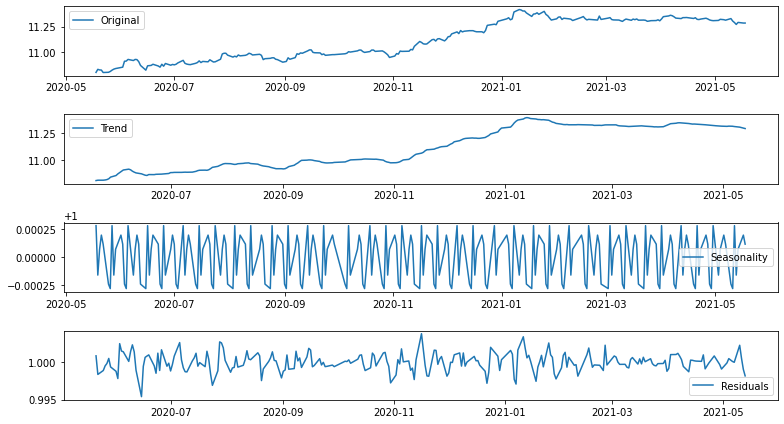

In [182]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 7) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

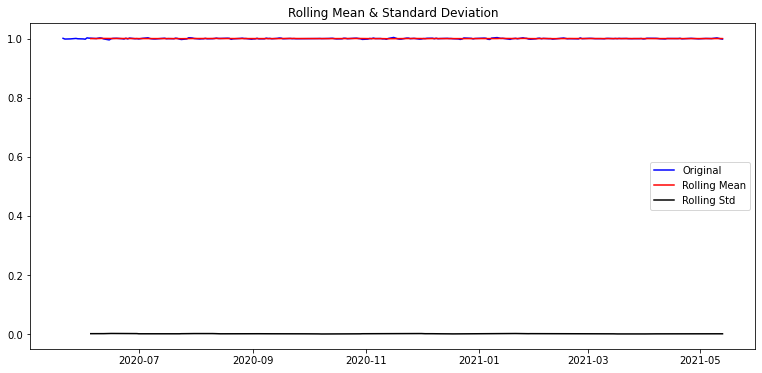

Results of Dickey-Fuller Test:
Test Statistic                -9.839670e+00
p-value                        4.790668e-17
#Lags Used                     5.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [183]:
# Residual 안정성 확인 
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

## Step 4. 학습, 테스트 데이터셋 생성

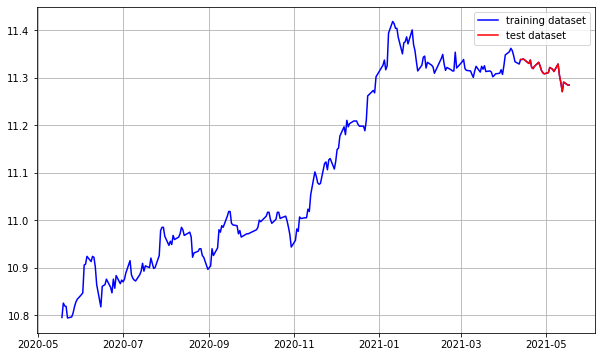

In [184]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='b', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='r', label='test dataset')
plt.legend()

In [185]:
# 데이터셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## Step 5. 적정 ARIMA 모수 찾기
#### * ACF, PACF 그려보기 -> p, q 구하기
#### * 차분 안정성 확인 -> d 구하기

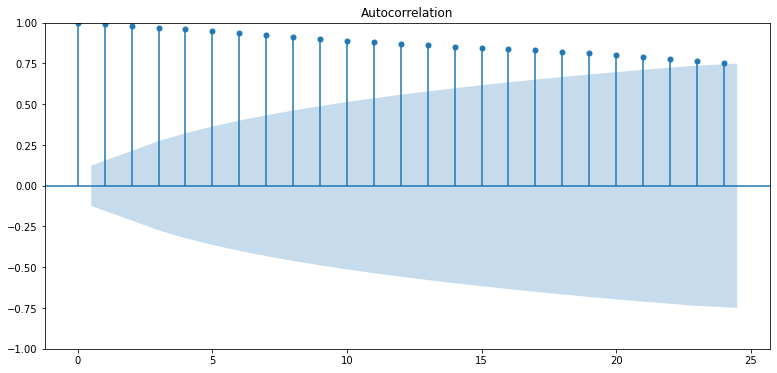

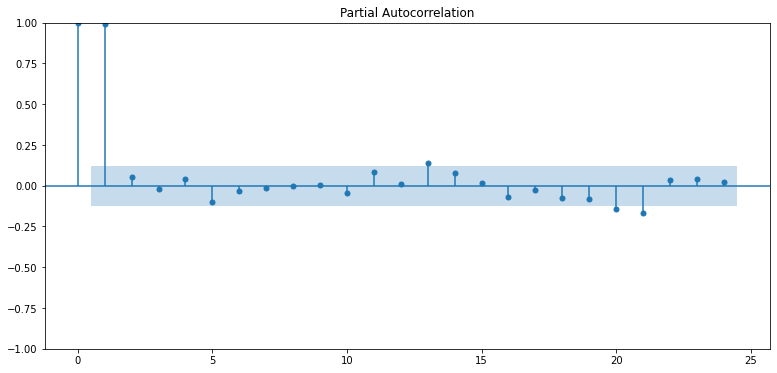

In [186]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


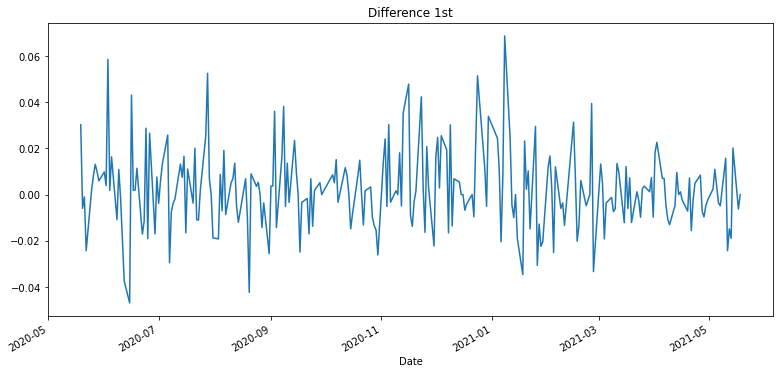

In [187]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


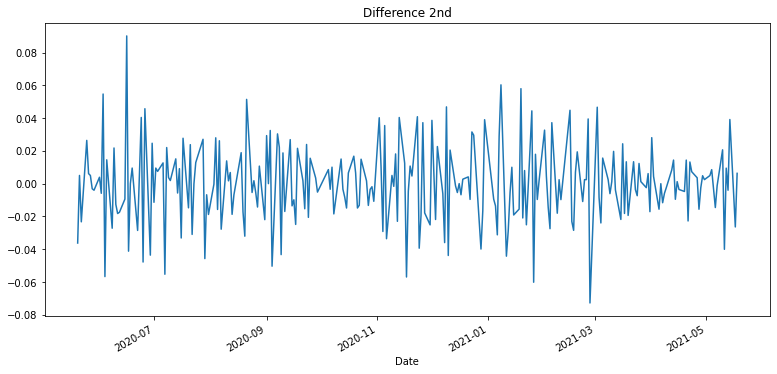

In [188]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -8.066373e+00
p-value                        1.592247e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


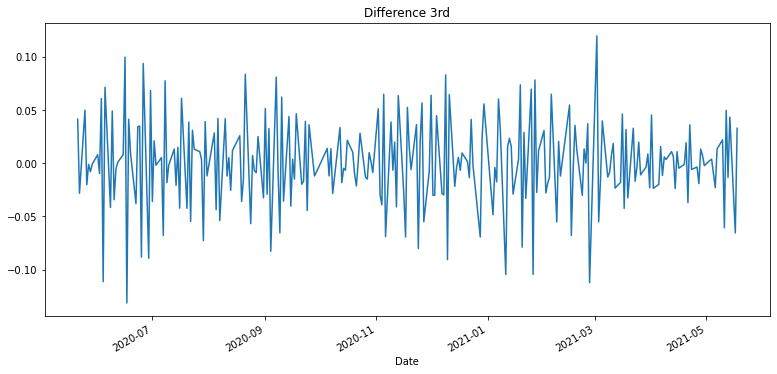

In [189]:
# 3차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

## Step 6. ARIMA 모델 훈련과 테스트
#### * ARIMA 모델 빌드와 훈련
#### * 모델 테스트 및 플로팅
#### * 최종 예측 모델 정확도 측정(MAPE)

In [190]:
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(2, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 583.501
Date:                Thu, 05 May 2022   AIC                          -1161.003
Time:                        11:07:15   BIC                          -1150.768
Sample:                             0   HQIC                         -1156.871
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0367      0.062      0.592      0.554      -0.085       0.158
ar.L2         -0.0112      0.076     -0.147      0.883      -0.160       0.138
sigma2         0.0003   2.47e-05     12.961      0.0

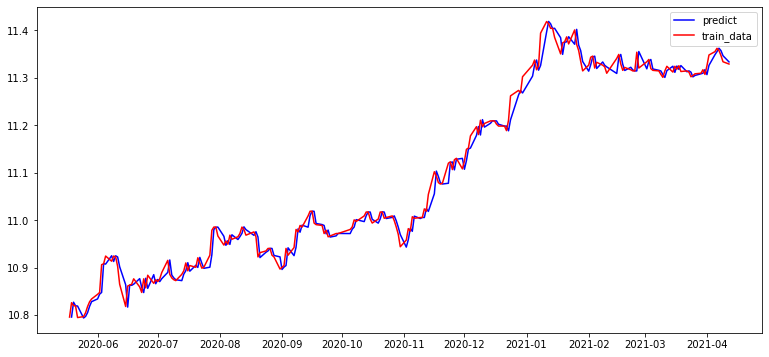

In [191]:
# 훈련결과 시각적으로 확인
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, c='b', label='predict')
plt.plot(train_data, c='r', label='train_data')
plt.legend()

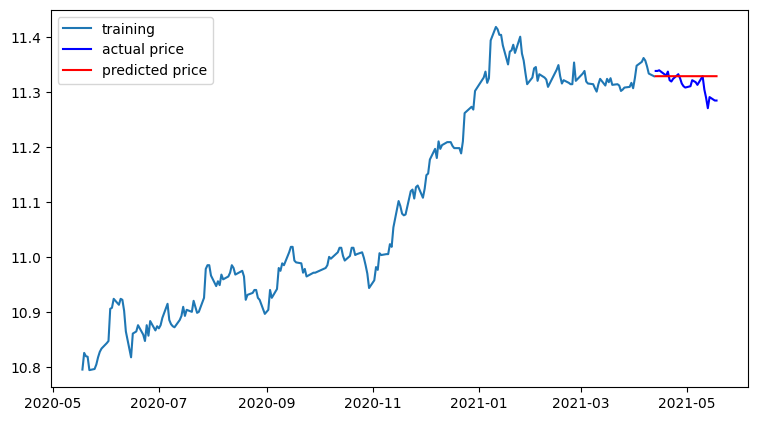

In [192]:
# 테스트 데이터 구간 데이터를 예측

# Forecast : 결과가 fc에 담깁니다. 
model = ARIMA(train_data, order=(2, 1, 0))  # p값을 2으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [193]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3514270.8102485035
MAE:  1409.0883491543018
RMSE:  1874.638847951387
MAPE: 1.74%


## Step 7. 다른 주식 종목 예측해 보기(1) : 

In [ ]:
# 시계열 데이터 불러와서 기본 확인
# 클라우드서버 경로 지정해 주고, 파일 읽어들여 데이터프레임 ts에 저장
#dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
#ts_original = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True)

# 구글드라이브에서 파일 불러오기
from google.colab import drive
drive.mount('/content/drive')

filename1 = '/content/drive/My Drive/035720.KS.csv'
ts1_original = pd.read_csv(filename1)
print(type(ts1_original))
ts1_original.head()

In [ ]:
ts1 = ts1_original['Close']
print(type(ts1))
print(ts1)

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  # 차트 기본 사이즈 설정

# 시계열 데이터를 차트로 그려봄
plt.plot(ts1)

In [ ]:
# 결측치 처리
ts1_na=ts[ts1.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력 => 결측치 없음
#plt.plot(ts1)
#plt.show()

In [ ]:
# 로그 변환 : 분석을 용이하게 하기 위해 큰 값은 크게, 작은 값은 작게 조정
ts1_log = np.log(ts1)
plt.plot(ts1_log)
plt.show()

In [ ]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 7) 

trend1 = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal1 = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual1 = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts1_log, label='Original1')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend1, label='Trend1')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal1,label='Seasonality1')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual1, label='Residuals1')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인 
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual1)
residual1.dropna(inplace=True)
augmented_dickey_fuller_test(residual1)

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split
train_data1, test_data1 = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='b', label='training dataset1')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data1, c='r', label='test dataset1')
plt.legend()

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff1_1 = ts1_log.diff(periods=1).iloc[1:]
diff1_1.plot(title='Difference1 1st')

augmented_dickey_fuller_test(diff1_1)

In [ ]:
# 2차 차분 구하기
diff1_2 = diff1_1.diff(periods=1).iloc[1:]
diff1_2.plot(title='Difference1 2nd')

augmented_dickey_fuller_test(diff1_2)

In [ ]:
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train_data1, order=(2, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m1 = model1.fit() 

print(fitted_m1.summary())

In [ ]:
# 훈련결과 시각적으로 확인
fitted_m1 = fitted_m1.predict()
fitted_m1 = fitted_m1.drop(fitted_m1.index[0])
plt.plot(fitted_m1, c='b', label='predict1')
plt.plot(train_data1, c='r', label='train_data1')
plt.legend()

In [ ]:
# 테스트 데이터 구간 데이터를 예측

# Forecast : 결과가 fc에 담깁니다. 
model1 = ARIMA(train_data1, order=(2, 1, 0))  # p값을 2으로 테스트
fitted_m1 = model1.fit() 
fc1= fitted_m1.forecast(len(test_data1), alpha=0.05)  # 95% conf
fc1 = np.array(fc)
# Make as pandas series
fc1_series = pd.Series(fc1, index=test_data1.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data1, label='training1')
plt.plot(test_data1, c='b', label='actual price1')
plt.plot(fc1_series, c='r',label='predicted price1')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse1 = mean_squared_error(np.exp(test_data1), np.exp(fc))
print('MSE1: ', mse1)

mae1 = mean_absolute_error(np.exp(test_data1), np.exp(fc))
print('MAE1: ', mae1)

rmse1 = math.sqrt(mean_squared_error(np.exp(test_data1), np.exp(fc)))
print('RMSE1: ', rmse1)

mape1 = np.mean(np.abs(np.exp(fc1) - np.exp(test_data1))/np.abs(np.exp(test_data1)))
print('MAPE1: {:.2f}%'.format(mape1*100))

## Step 7. 다른 주식 종목 예측해 보기(2) : 

In [ ]:
# 시계열 데이터 불러와서 기본 확인
# 클라우드서버 경로 지정해 주고, 파일 읽어들여 데이터프레임 ts에 저장
#dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
#ts_original = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True)

# 구글드라이브에서 파일 불러오기
from google.colab import drive
drive.mount('/content/drive')

filename2 = '/content/drive/My Drive/035420.KS.csv'
ts2_original = pd.read_csv(filename2)
print(type(ts2_original))
ts2_original.head()

In [ ]:
ts2 = ts2_original['Close']
print(type(ts2))
print(ts2)

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  # 차트 기본 사이즈 설정

# 시계열 데이터를 차트로 그려봄
plt.plot(ts2)

In [ ]:
# 결측치 처리
ts2_na=ts[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력 => 결측치 없음
#plt.plot(ts2)
#plt.show()

In [ ]:
# 로그 변환 : 분석을 용이하게 하기 위해 큰 값은 크게, 작은 값은 작게 조정
ts2_log = np.log(ts2)
plt.plot(ts2_log)
plt.show()

In [ ]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 7) 

trend2 = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal2 = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual2 = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts2_log, label='Original2')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend2')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality2')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals2')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인 
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual2)
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split
train_data2, test_data2 = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='b', label='training dataset2')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='r', label='test dataset2')
plt.legend()

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff2_1 = ts2_log.diff(periods=1).iloc[1:]
diff2_1.plot(title='Difference2 1st')

augmented_dickey_fuller_test(diff2_1)

In [ ]:
# 2차 차분 구하기
diff2_2 = diff2_1.diff(periods=1).iloc[1:]
diff2_2.plot(title='Difference2 2nd')

augmented_dickey_fuller_test(diff2_2)

In [ ]:
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model2 = ARIMA(train_data2, order=(2, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m2 = model2.fit() 

print(fitted_m2.summary())

In [ ]:
# 훈련결과 시각적으로 확인
fitted_m2 = fitted_m2.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, c='b', label='predict2')
plt.plot(train_data2, c='r', label='train_data2')
plt.legend()

In [ ]:
# 테스트 데이터 구간 데이터를 예측

# Forecast : 결과가 fc에 담깁니다. 
model2 = ARIMA(train_data2, order=(2, 1, 0))  # p값을 2으로 테스트
fitted_m2 = model2.fit() 
fc2= fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf
fc2 = np.array(fc2)
# Make as pandas series
fc2_series = pd.Series(fc2, index=test_data2.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data2, label='training2')
plt.plot(test_data2, c='b', label='actual price2')
plt.plot(fc2_series, c='r',label='predicted price2')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc))
print('MSE2: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc))
print('MAE2: ', mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc)))
print('RMSE2: ', rmse2)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE2: {:.2f}%'.format(mape2*100))

# [ 루브릭 ]
---
### 1. 시계열의 안정성이 충분히 확인되었는가?
#### * 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
<br><br><

### 2. ARIMA모델 모수선택 근거를 체계적으로 제시하였는가?
#### * p, q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
<br><br>

### 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
#### * 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨.
---
<br><br><br><br>

# [ 회고 ]

#### 시계열 분석에 대한 전반적인 내용에 대해서는 어느 정도 이해가 된 것 같은데, 
#### 모델의 예측값을 향상시키기 위한 모수 선택 방법에 대해서는 좀 더 공부를 해야겠네요.

#### 추가 두 종목에 대한 분석은 yahoo finance 사이트에서 다운로드 받은 파일을 가지고 
#### Colab에서 진행하려고 했는데, 동일한 코드 진행인데 Colab에서 오류가 난 것을
#### 해결하지 못해서 코드만 남기고 올리게 되었습니다.
